In [34]:
import numpy as np
import pandas as pd
import seaborn as sns

horizon = 5
days = horizon * 251
names = 10
risk_free = 0.03
risk_free_daily = (1 + risk_free)**(1/252) - 1
tax_long = 0.2
tax_long_ = 0.25
tax_short = 0.3
tax_short_ = 0.35
threshold = 0.15

np.random.seed(1012)
seeds = np.random.randint(1, 10e6, 1000)

# second list for each strategy is used for tax rate change in the future
buy_and_hold = []
buy_and_hold_2 = []
loss_harvesting = []
loss_harvesting_2 = []
loss_harvesting_daily = []
loss_harvesting_daily_2 = []
loss_harvesting_threshold = []
loss_harvesting_threshold_2 = []

# 1000 simulations:

for each in seeds:
    
    # generate volatilities for the 10 SPs
    np.random.seed(each)
    vol_annual = np.random.uniform(low=0.15, high=0.45, size=names).reshape((1, names))
    vol_daily = vol_annual / np.sqrt(252)
    
    # generate daily prices for the 10 SPs in 5 years
    random_part = np.exp(np.random.normal(size=days*names).reshape((days, names)) * vol_daily +\
                     (risk_free_daily-0.5*vol_daily**2))
    data = np.cumprod(random_part, axis=0)
    data = np.vstack((np.ones(names), data))
    
    # based on the price data, we can perform different strategies
    
    # buy and hold
    gain_1 = data[-1] - data[0]
    buy_and_hold.append(np.sum(data[-1]) - tax_long * np.sum(gain_1))
    buy_and_hold_2.append(np.sum(data[-1]) - tax_long_ * np.sum(gain_1))
    
    # periodical TLH
    cost = np.vstack((np.zeros(names), np.ones(names)))
    value_loss = 0
    for term in range(1, horizon+1):
        temp = data[term*251] - cost[1]
        temp_loss = np.where(temp<0, -temp, 0)
        loss_short = np.sum(np.where(cost[0] >= term-1, temp_loss, 0))
        loss_long = np.sum(np.where(cost[0] < term-1, temp_loss, 0))
        cost[0] = np.where(temp<0, term, cost[0])
        cost[1] = np.where(temp<0, data[term*251], cost[1])
        value_loss += (loss_short*tax_short+loss_long*tax_long)*(1+risk_free_daily)**((horizon-term)*251)
    gain_2 = data[-1]-cost[1]
    gain_long = np.sum(np.where(cost[0] < horizon-1, gain_2, 0))
    gain_short = np.sum(np.where(cost[0] >= horizon-1, gain_2, 0))
    loss_harvesting.append(np.sum(data[-1]) - tax_long * gain_long - tax_short * gain_short + value_loss)
    loss_harvesting_2.append(np.sum(data[-1]) - tax_long_ * gain_long - tax_short_ * gain_short + value_loss)
    
    # daily TLH
    cost = np.vstack((np.zeros(names), np.ones(names)))
    value_loss = 0
    for term in range(1, days+1):
        temp = data[term] - cost[1]
        temp_loss = np.where(temp < 0, -temp, 0)
        loss_short = np.sum(np.where(cost[0] >= term-251, temp_loss, 0))
        loss_long = np.sum(np.where(cost[0] < term-251, temp_loss, 0))
        cost[0] = np.where(temp < 0, term, cost[0])
        cost[1] = np.where(temp < 0, data[term], cost[1])
        value_loss += (loss_short*tax_short + loss_long*tax_long) * (1+risk_free_daily)**(days-term)
    gain_3 = data[-1]-cost[1]
    gain_long = np.sum(np.where(cost[0] < days-251, gain_3, 0))
    gain_short = np.sum(np.where(cost[0] >= days-251, gain_3, 0))
    loss_harvesting_daily.append(np.sum(data[-1]) - tax_long * gain_long - tax_short * gain_short + value_loss)
    loss_harvesting_daily_2.append(np.sum(data[-1]) - tax_long_ * gain_long - tax_short_ * gain_short + value_loss)
    
    # TLH with threshold
    cost = np.vstack((np.zeros(names), np.ones(names)))
    value_loss = 0
    for term in range(1, days+1):
        temp_loss = np.where(data[term] < (1-threshold) * cost[1], cost[1] - data[term], 0)
        loss_short = np.sum(np.where(cost[0] >= term-251, temp_loss, 0))
        loss_long = np.sum(np.where(cost[0] < term-251, temp_loss, 0))
        cost[0] = np.where(data[term] < (1-threshold) * cost[1], term, cost[0])
        cost[1] = np.where(data[term] < (1-threshold) * cost[1], data[term], cost[1])
        value_loss += (loss_short*tax_short + loss_long*tax_long) * (1+risk_free_daily)**(days-term)
    gain_4 = data[-1]-cost[1]
    gain_long = np.sum(np.where(cost[0] < days-251, gain_4, 0))
    gain_short = np.sum(np.where(cost[0] >= days-251, gain_4, 0))
    loss_harvesting_threshold.append(np.sum(data[-1]) - tax_long * gain_long - tax_short * gain_short + value_loss)
    loss_harvesting_threshold_2.append(np.sum(data[-1]) - tax_long_ * gain_long - tax_short_ * gain_short + value_loss)

# calculate total rate of return for each list
ROR_bah = (np.array(buy_and_hold) - names) / names * 100
ROR_bah_2 = (np.array(buy_and_hold_2) - names) / names * 100
ROR_annual = (np.array(loss_harvesting) - names) / names * 100
ROR_annual_2 = (np.array(loss_harvesting_2) - names) / names * 100
ROR_daily = (np.array(loss_harvesting_daily) - names) / names * 100
ROR_daily_2 = (np.array(loss_harvesting_daily_2) - names) / names * 100
ROR_thresh = (np.array(loss_harvesting_threshold) - names) / names * 100
ROR_thresh_2 = (np.array(loss_harvesting_threshold_2) - names) / names * 100

In [23]:
sns.set()
plt.rc('text', usetex=True)
plt.rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
x = np.arange(1, 1001)

<IPython.core.display.Javascript object>


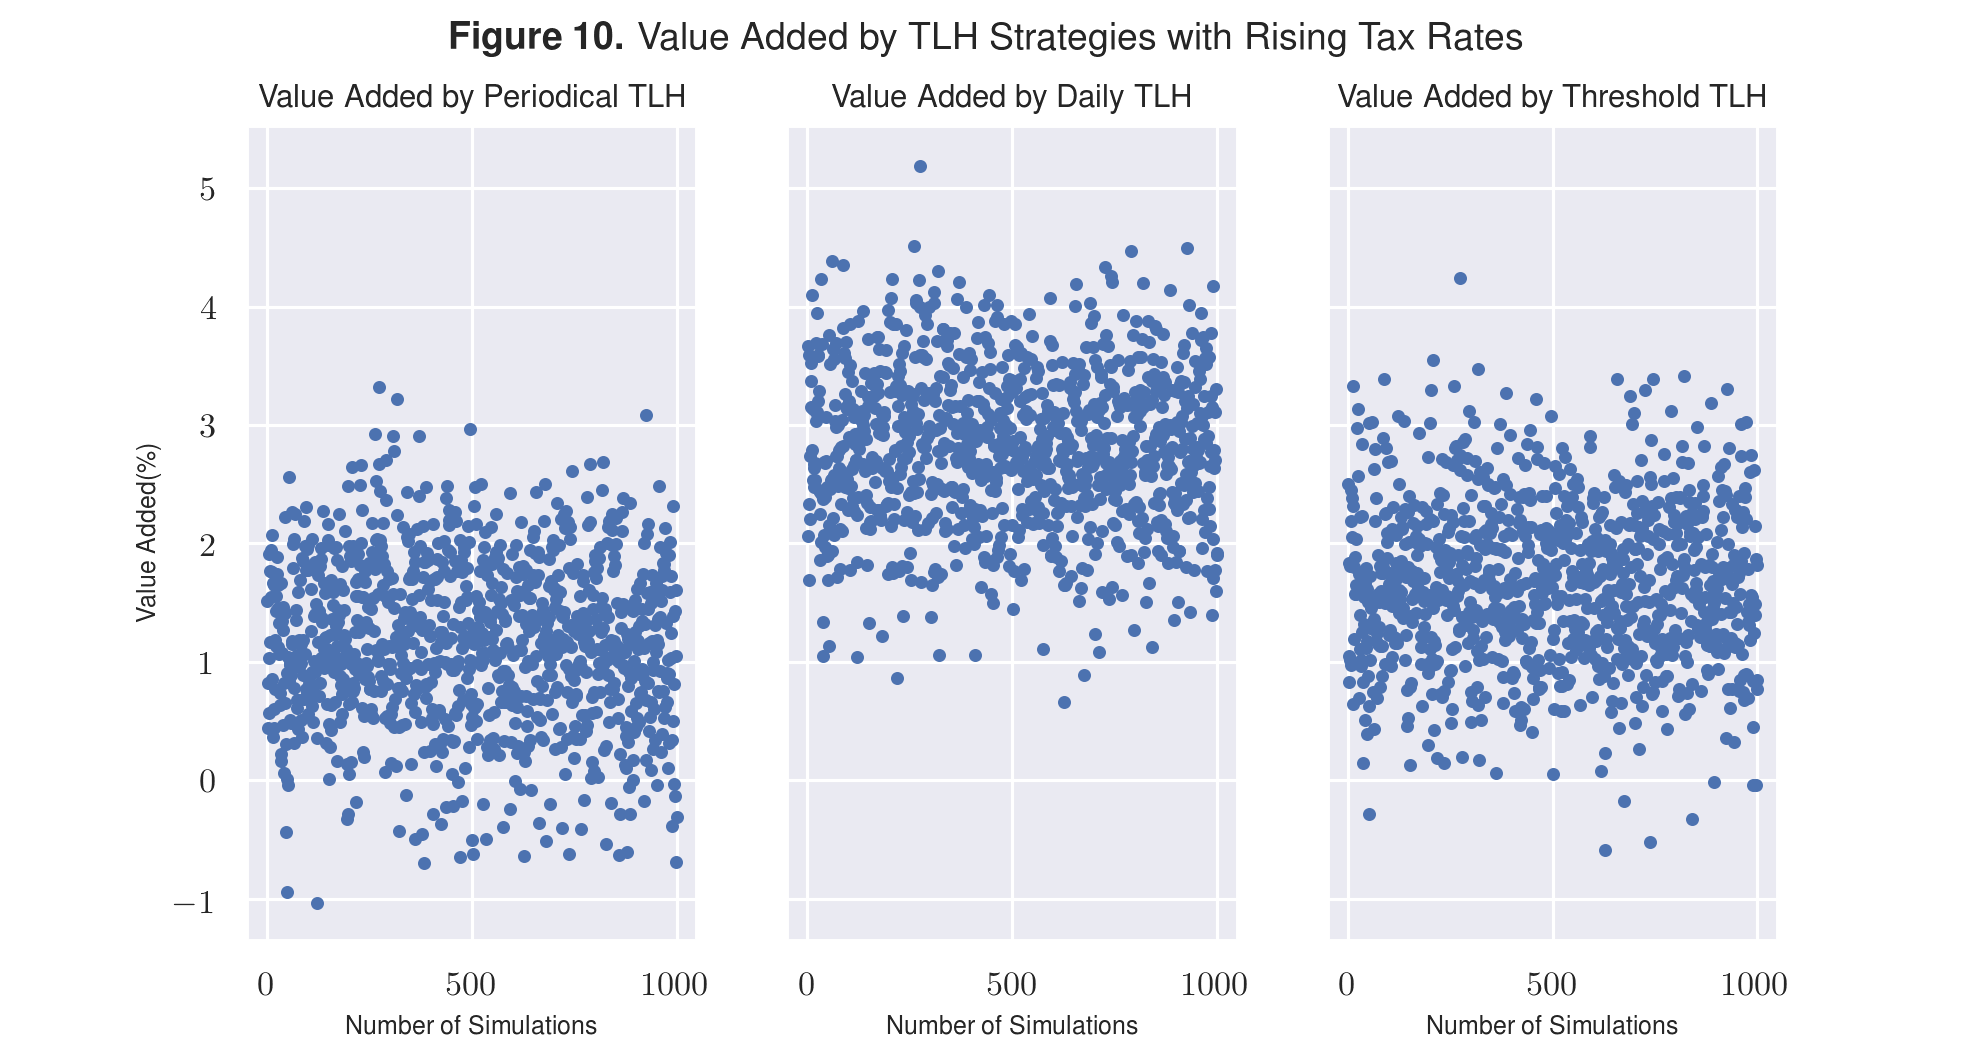

Text(0.5,0,'Number of Simulations')

In [30]:
# Figure 10
%matplotlib notebook
plt.suptitle(r'\textbf{Figure 10. }Value Added by TLH Strategies with Rising Tax Rates', size=12)

ax1 = plt.subplot('131')
ax1.scatter(x, ROR_annual - ROR_bah, s=10)
ax1.set_title(r'Value Added by Periodical TLH', size=10)
ax1.set_ylabel(r'Value Added(\%)', size=8)
ax1.set_xlabel(r'Number of Simulations', size=8)

ax2 = plt.subplot('132', sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.scatter(x, ROR_daily - ROR_bah, s=10)
ax2.set_title(r'Value Added by Daily TLH', size=10)
ax2.set_xlabel(r'Number of Simulations', size=8)

ax3 = plt.subplot('133', sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.scatter(x, ROR_thresh - ROR_bah, s=10)
ax3.set_title(r'Value Added by Threshold TLH', size=10)
ax3.set_xlabel(r'Number of Simulations', size=8)